In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units
import camb
from camb import model, initialpower
import pymaster as nmt
import time
import utils

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [6]:
import matplotlib

# functions

In [24]:
def plot_ps(cls, label):
#     plt.figure(figsize = (10,8));
    
    if len(cls.shape) == 1:
        _ell = np.arange(len(cls)); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2:], '-',label = label );
        
    else:
        _ell = np.arange(len(cls[0])); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[1][2:],label = 'EE');
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2][2:],label = 'BB');
    
    plt.legend(fontsize = 20);

    
ali_ma = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits', verbose=False)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

def smooth(maps, beam_out, lmax):
    _maps = np.copy(maps);
    for j in range(0,3):                        ###for Q and U. Exclude I.
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps

In [225]:
ali_ma_512 = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits')
def Mask_0(maps_raw):
    
    '''
    The masked values are equal to 0.
    '''
    maps = np.copy(maps_raw)
    index0 = np.arange(len(ali_ma_512));
    mask_index0 = index0[np.where(ali_ma_512<1)]
    
    _ndim = len(maps.shape)
    if _ndim > 2:  ### (Nf, 3, npix)
        for i in range(maps.shape[0]):
            for j in range(3):
                maps[i,j][mask_index0] = 0
    elif _ndim == 2: ### (3, npix)
        for j in range(maps.shape[0]):
            maps[j][mask_index0] = 0
    
    else: ### (npix)
        maps[mask_index0] = 0
    return maps

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Check for Shamik

In [7]:
nside = 512; lmax = 1000

In [118]:
cls_0 = np.loadtxt('cls_r_0.txt'); cls_0p01 = np.loadtxt('cls_r_0p01.txt'); cls_0p05 = np.loadtxt('cls_r_0p05.txt'); cls_0p1 = np.loadtxt('cls_r_0p1.txt')

In [137]:
ali_ma512 = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_wdge_512.fits', verbose=False)

mask = nmt.mask_apodization(ali_ma512, 6, apotype='C2') 

In [180]:
fsky = np.sum(ali_ma512)/12/nside**2

In [190]:
bl = hp.gauss_beam(19/60/180*np.pi, lmax = 3*nside)

In [191]:
SamNum = 100; Cls= []; b = nmt.NmtBin(nside, nlb=11, lmax=1000); Cls_real = []; Cls_all = []

for i in range(SamNum):
    
    if i < 3:
        start = time.time()
        
    cmb_real_1024_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%i, field = None, verbose = False)
    alms = hp.map2alm(cmb_real_1024_i)
    cmb_real_i = Mask_0(hp.alm2map(alms, nside = 512, fwhm=19/60/180*np.pi, verbose = False))
    
    cmb_clean_i = hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%i, field = None, verbose = False)
    
    m_q, m_u = cmb_real_i[1] - cmb_clean_i[0], cmb_real_i[2] - cmb_clean_i[1]
    
    b_no_e = nmt.NmtField(mask, [m_q, m_u], purify_e=False, purify_b=True, beam=bl) 
    
    cl_i = nmt.compute_full_master(b_no_e, b_no_e,b) ## spin-2 x spin-2  # residuals
    
    b_real = nmt.NmtField(mask,cmb_real_i[1:], purify_e=False, purify_b=True, beam=bl)
    cl_real_i = nmt.compute_full_master(b_real, b_real, b) # real
    
    b_all = nmt.NmtField(mask, cmb_clean_i, purify_e=False, purify_b=True, beam=bl)  
    cl_all_i = nmt.compute_full_master(b_all, b_all, b) # cleaned
    
    Cls.append(cl_i[3]); Cls_real.append(cl_real_i[3]); Cls_all.append(cl_all_i[3])
    
    if i < 3:
        end = time.time()
        print('Time cost is: %s mins'%(end - start))
# cmb_clean = np.row_stack((np.ones(12*1024**2), cmb_clean))

Time cost is: 29.879783153533936 mins
Time cost is: 36.93956160545349 mins
Time cost is: 47.21826791763306 mins


In [192]:
ell_arr = b.get_effective_ells()

In [193]:
el2 = utils.l2(ell_arr)

Text(0, 0.5, '$\\delta D_{\\ell}^{BB}[\\mu K^2]$')

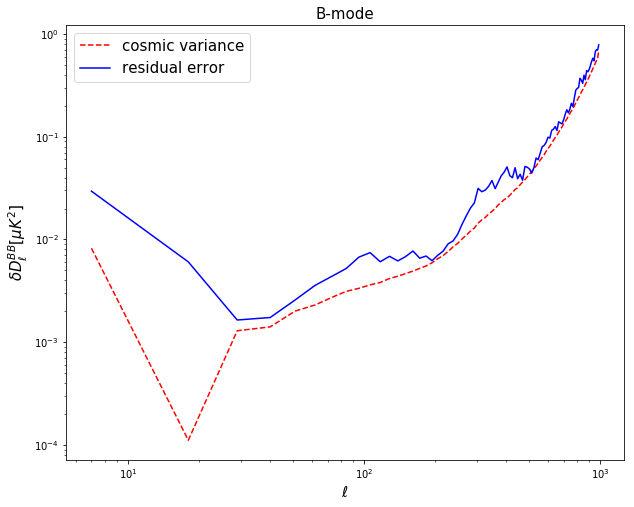

In [223]:
plt.loglog(ell_arr, np.sqrt(2/((2*ell_arr + 1)*fsky*11))*el2*np.mean(Cls_all, axis = 0), 'r--',label = 'cosmic variance')

# plt.loglog(ell_arr, el2*np.mean(Cls_real, axis = 0), 'g-',label = 'mean real')
plt.title('B-mode', fontsize = 15)
plt.loglog(ell_arr, el2*np.std(Cls, axis = 0), 'b-',label = 'residual error')
# plt.ylim(6*1e-4, 20)
plt.legend(fontsize = 15)
plt.xlabel('$\ell$', fontsize = 15); plt.ylabel('$\delta D_{\ell}^{BB}[\mu K^2]$', fontsize = 15)
# plt.xlim(20,)

# Namaster for ILC

In [112]:
beam_low = 27.9435; nside = 512; lmax = 1000

b = nmt.NmtBin(nside, nlb=10, lmax=lmax); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)
bl = hp.gauss_beam(beam_low/60/180*np.pi, lmax = 3*nside)

In [113]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [114]:
ali_ma_512 = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits", verbose=False)
mask = nmt.mask_apodization(ali_ma_512,  6, apotype='C2')
# hp.mollview(mask, title='Apodized mask')

In [115]:
cmb_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(1), field = None, verbose = False)
alm_i = hp.map2alm(cmb_i); 
cmb_512_beam = hp.alm2map(alm_i, nside = nside, fwhm=beam_low/60/180*np.pi)
m0 = nmt.NmtField(mask, cmb_512_beam[1:], purify_e=False, purify_b=True, beam=bl)

Sigma is 11.866512 arcmin (0.003452 rad) 
-> fwhm is 27.943500 arcmin


In [116]:
# using workspace calculate the coupling matrix first.

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(m0, m0, b)

In [117]:
SamNum = 100; Cl_cmb = []
for n in range(SamNum):
    cmb_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(n), field = None, verbose = False)
    alm_i = hp.map2alm(cmb_i); 
    cmb_512_beam = hp.alm2map(alm_i, nside = nside, fwhm=beam_low/60/180*np.pi, verbose = False)
    
    m0 = nmt.NmtField(mask, cmb_512_beam[1:], purify_e=False, purify_b=True, beam=bl)
    
    Cl_cmb.append(compute_master(m0, m0, w)[3])

In [118]:
Cl_cmb = np.array(Cl_cmb)

In [119]:
cl_mean = np.mean(Cl_cmb, axis = 0)

In [120]:
np.save('/fnx/jianyao/cmb_0.05_realizations/cl_mean_namaster_44.npy', cl_mean)

In [121]:
cl_hana = hp.anafast(cmb_i, nspec = 3, lmax = lmax)
ell = np.arange(len(cl_hana[2])); el2 = ell*(ell+1)/2/np.pi

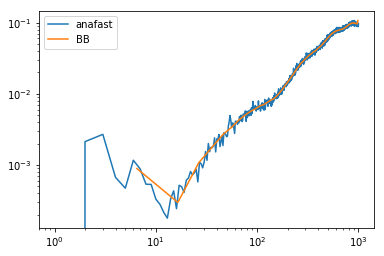

In [124]:
plt.loglog(ell,el2*cl_hana[2], label = 'anafast')
plt.loglog(ell_n, eln2*cl_mean, label = 'BB')
plt.xlim(0.7,)
plt.legend()

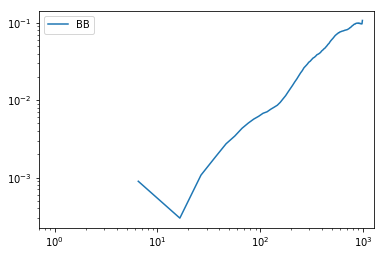

In [123]:
plt.loglog(ell_n, eln2*cl_mean, label = 'BB')
plt.xlim(0.7,)
plt.legend()

# Correction for E-B leakage in pixel domain

In [242]:
cl_camb = np.loadtxt('./cls_r_0p05.txt')
cmb_i =  hp.synfast(cl_camb, nside = 512, verbose = False, new = True)

In [287]:
cl_full = hp.anafast(cmb_i,nspec = 3, lmax = 1000)

cmb_masked = Mask_0(cmb_i)

cl_cor_hp = hp.anafast(cmb_masked, lmax = 1000, nspec = 3); 

ell = np.arange(len(cl_cor_hp[2])); el2 = utils.l2(ell)

In [285]:
alm_full = hp.map2alm(cmb_i);
Bmap_full = hp.alm2map(alm_full[2], nside = nside)

Bmap_masked = Mask_0(Bmap_full)
cl_Bmap_masked = hp.anafast(Bmap_masked, lmax = 1000)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [297]:
cl_resi_hp = hp.anafast(map_resi, lmax = 1000)

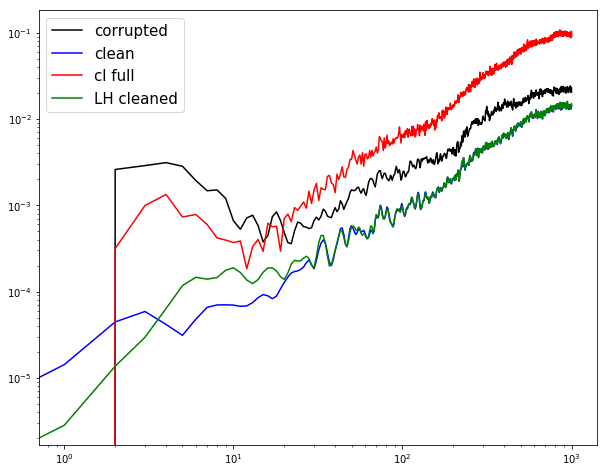

In [304]:
plt.figure(figsize = (10,8))
plt.loglog(ell, el2*cl_cor_hp[2], 'k-',label = 'corrupted')
plt.loglog(ell, el2*cl_Bmap_masked, 'b-',label = 'clean')

plt.loglog(ell, el2*cl_full[2],'r-', label = 'cl full')

plt.loglog(ell, el2*cl_resi_hp,'g-', label = 'LH cleaned')


plt.legend(fontsize = 15)

> get corrupted alm_TEB
 call map2alm_iterative(nside,lmax,lmax,niter,map,alm,mask=mask)

> get corrupted B-map
almB(1,:,:) = alm(3,:,:)
call alm2map (nside,lmax,mmax,almB,BO)

> get corrupted alm_E and convert to IQU
alm(1,:,:) = dcmplx(0,0)
alm(3,:,:) = dcmplx(0,0)
call alm2map (nside,lmax,mmax,alm,map)

> convert to alm with mask applied again
call map2alm_iterative(nside,lmax,lmax,niter,map,alm,mask=mask)

> get the leakage template
almB(1,:,:) = alm(3,:,:)
call alm2map (nside,lmax,mmax,almB,BT)

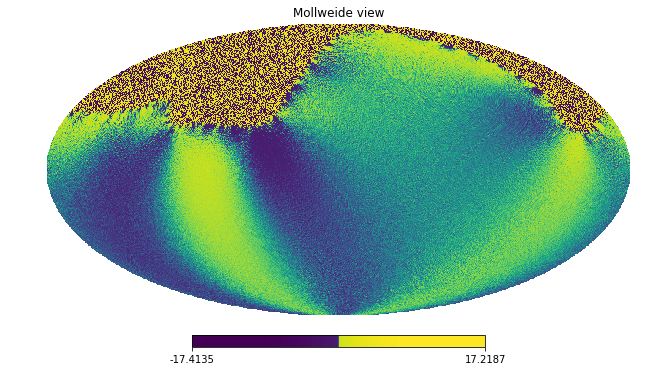

In [318]:
hp.mollview(map_E[2], norm = 'hist')#, cmap = 'coolwarm')

In [332]:
list1.shape

(457468,)

In [331]:
cmb_i[0][np.where(ali_ma_512 == 1)].shape

(457468,)

In [179]:
## mask info

n1 = sum(ali_ma_512); npix = np.arange(len(ali_ma_512)) 
list1 = npix[ali_ma_512 == 1] ### index of the available pixles

nside = 512; 

## get the template of E to B leakage 
alm_ma = hp.map2alm(cmb_masked) #alms of the masked maps

B0 = hp.alm2map(alm_ma[2], nside = nside, verbose = False) ## corrupted B map

alm_ma[0] = 0; alm_ma[2] = 0; map_E = hp.alm2map(alm_ma, nside, verbose = False) ### IQU of corrupted E mode only

alm_new = hp.map2alm(Mask_0(map_E))

BT = hp.alm2map(alm_new[2], nside = nside, verbose = False) ## template of E to B leakage 

In [181]:
def lin_resi(x, y, n):
    mx  = sum(x)/n; my  = sum(y)/n;
    cxx = sum((x-mx)*(x-mx)); cxy = sum((y-my)*(x-mx))
    a1  = cxy/cxx 
    a0  = my - mx*a1 
    resi  = y - a0 - a1*x
    
    map0 = np.zeros(12*nside**2);
    map0[list1] = resi
    
    return map0

In [290]:
map_resi = lin_resi(BT[list1], B0[list1], n1)

In [291]:
m1 = nmt.NmtField(mask,[map_resi])

cl_resi = nmt.compute_full_master(m1, m1, b)

In [305]:
m2 = nmt.NmtField(mask,cmb_i[1:])

cl_cor = nmt.compute_full_master(m2, m2, b)

In [293]:
m3 = nmt.NmtField(mask,cmb_i[1:],purify_e=False, purify_b=True )
cl_puri = nmt.compute_full_master(m3, m3, b)

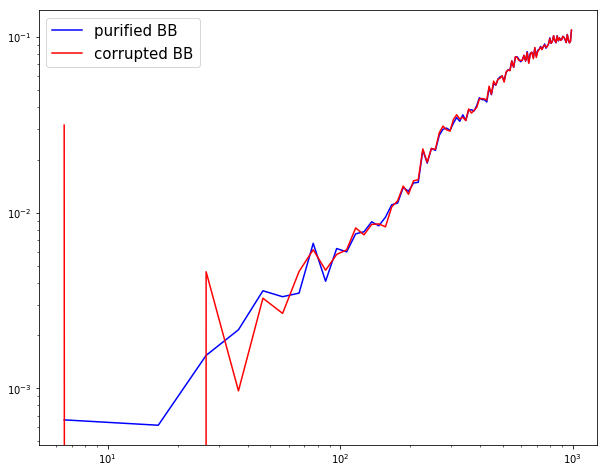

In [308]:
plt.figure(figsize = (10,8))
# plt.loglog(ell,el2*cl_full[2], 'g--',label = 'full-sky BB')
plt.loglog(ell_n, eln2*cl_resi[0], 'b-',label = 'purified BB')
plt.loglog(ell_n, eln2*cl_cor[3], 'r-',label = 'corrupted BB')

# plt.loglog(ell_n, eln2*cl_puri[3], 'g-',label = 'Namaster-purified BB')

plt.legend(fontsize = 15)

# Test for the class

# Class for E-B leakage

In [337]:
class PurifyB(object):
   
    def __init__(self, maps, mask):
         
        '''
        Parameters
        ----------
        
        mask : binary, 1 and 0;
        maps: IQU maps; The Mask_0() and hp.map2alm() require IQU as input.
        
        Example
        ----------
        
        purify = PurifyB(cmb_i, ali_ma_512)
        map_purified = purify.lin_resi()
        '''
        
        self.mask = mask; self.maps = maps; self.nside = hp.npix2nside(len(mask))
        self.pix_list = np.arange(len(mask)); self.mask_sum = sum(mask)
        self.mask_index = self.pix_list[np.where(mask < 1)] # the pixel index of the masked index
        self.avai_index = self.pix_list[np.where(mask == 1)] # the pixel index of the available index
        
    def Mask_0(self, maps_raw):
    
        '''
        Mask the maps. The masked values are equal to 0.
        maps_raw: the maps to be masked, the shape of which must be (Nf, 3, npix), (3, npix), or (npix).

        '''
        _maps = np.copy(maps_raw)

        _ndim = len(_maps.shape)

        if _ndim > 2:  ### (Nf, 3, npix)
            for i in range(_maps.shape[0]):
                for j in range(3):
                    _maps[i,j][self.mask_index] = 0
        elif _ndim == 2: ### (3, npix)
            for j in range(_maps.shape[0]):
                _maps[j][self.mask_index] = 0

        else: ### (npix)
            _maps[self.mask_index] = 0
        
        return _maps

    def lin_resi(self):
        
        '''
        Main function of this class to correct the E to B leakage.
        '''
        
        ### get the template of E to B leakage 
        
        alm_ma = hp.map2alm(Mask_0(self.maps)) #alms of the masked maps

        B0 = hp.alm2map(alm_ma[2], nside = self.nside, verbose = False) # corrupted B map
        
        alm_ma[0] = 0; alm_ma[2] = 0; map_E = hp.alm2map(alm_ma, nside = self.nside, verbose = False) # IQU of corrupted E mode only

        alm_new = hp.map2alm(Mask_0(map_E)) # alms of the IUQ from only E-mode 

        BT = hp.alm2map(alm_new[2], nside = self.nside, verbose = False) # template of E to B leakage 
        
        ### compute the residual of linear fit
        
        x = BT[self.avai_index]; y = B0[self.avai_index]
        
        mx  = sum(x)/self.mask_sum; my  = sum(y)/self.mask_sum;
        cxx = sum((x-mx)*(x-mx)); cxy = sum((y-my)*(x-mx))
        a1  = cxy/cxx 
        a0  = my - mx*a1 
        resi  = y - a0 - a1*x

        map0 = np.zeros(12*nside**2);
        map0[self.avai_index] = resi

        return map0

# Anisotropic and isotropic noise

In [71]:
n150cl = hp.anafast(noise_150, lmax = lmax)

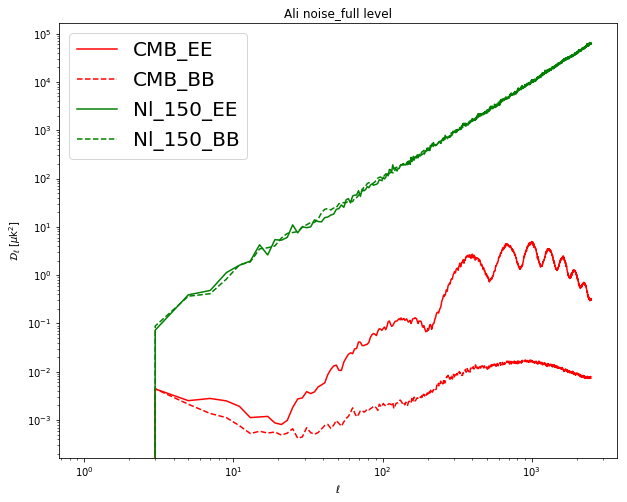

In [222]:
ell = np.arange(len(cmb_cl[0]))
plt.figure(figsize = (10,8))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[1]),'r', label = 'CMB_EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[2]),'r--', label = 'CMB_BB')
# plt.loglog(ell, ell*(ell+1)/2/np.pi*cmb_cl[2],'r--', label = 'CMB_BB')

# plt.subplot(121)
# plt.plot(ell, ell*(ell+1)/2/np.pi*ncl1, 'b-x')
# # # plt.subplot(122)
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[1]), 'k-', label = 'Nl_95_EE')
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[2]), 'k--', label = 'Nl_95_BB')

plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[1]), 'g', label = 'Nl_150_EE')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[2]), 'g--', label = 'Nl_150_BB')

plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Ali noise_full level')
plt.legend(fontsize = 20)
plt.savefig('./ps_full_area_cmb_noise.pdf', format = 'pdf')

In [213]:
white_noise = hp.read_map('/smc/jianyao/Ali_maps/full_white_noise_realization_150.fits', field = None)
wn_ma = Mask(white_noise)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [214]:
noise_150_full = hp.read_map('/smc/jianyao/Ali_maps/full_noise_realizations_150.fits',field = None, verbose=False)
noise_150_full_ma = Mask(noise_150_full)

In [215]:
#signal plus white noise
swn = cmb + white_noise
#signal plus anisotropic noise
sn = cmb + noise_150_full_ma

cmb_ma = Mask(cmb) 
sn_ma = Mask(sn) ; swn_ma = Mask(swn)

In [216]:
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)
sn_cls = hp.anafast(sn_ma, lmax = lmax, nspec = 3); 
nls = hp.anafast(noise_150_full_ma, lmax = lmax, nspec = 3)
swn_cls = hp.anafast(swn_ma, lmax = lmax, nspec = 3)
wnls = hp.anafast(wn_ma, lmax = lmax, nspec = 3)

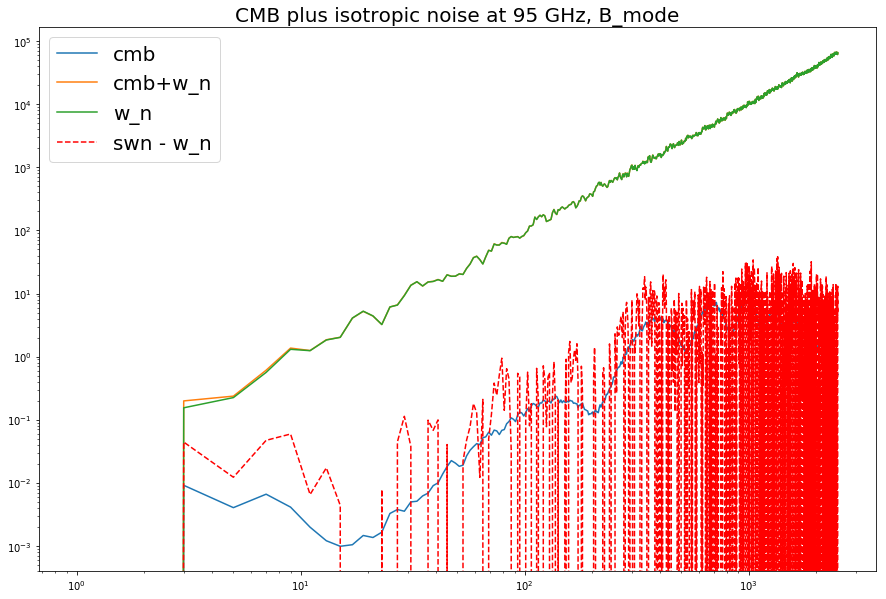

In [220]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0])); 
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), label = 'cmb')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(swn_cls[S]), label = 'cmb+w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(wnls[S]), label = 'w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'r--',label = 'swn - w_n')
plt.title('CMB plus isotropic noise at 95 GHz, B_mode', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./cmb_white_noise_95_GHz_B.pdf', format = 'pdf')

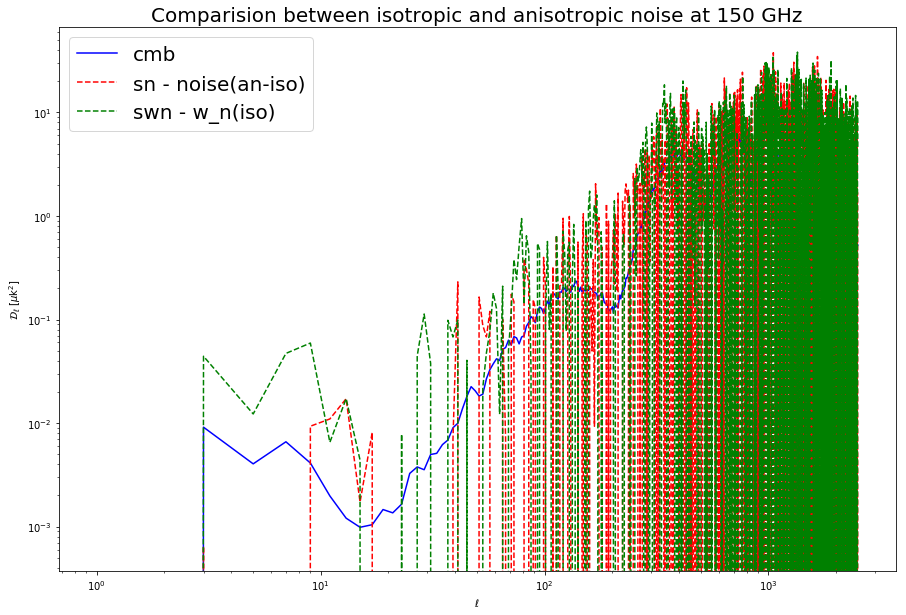

In [218]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0]))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), 'b-',label = 'cmb')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sn_cls[S]), label = 'cmb+noise')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[S]), label = 'noise')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((sn_cls[S] - nls[S])), 'r--',label = 'sn - noise(an-iso)')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'g--',label = 'swn - w_n(iso)')
plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Comparision between isotropic and anisotropic noise at 150 GHz', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./comparision_B_mode_150GHz.pdf', format = 'pdf')

In [138]:
# plt.figure(figsize = (15, 10));
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S]) - (sn_cls[S] - nls[S])), 'r--',label = 'swn - w_n')
# plt.savefig('recovery_nosie_difference_95_Bmode.pdf', format = 'pdf')